In [1]:
import os 
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
print(f'sklearn : {sklearn.__version__}')
print(f'keras : {keras.__version__}')
print(f'tensorflow : {tf.__version__}')

sklearn : 1.0.2
keras : 2.2.4-tf
tensorflow : 2.0.0


# 심층 신경망 훈련하기

이전에 몇 개의 은닉층으로 이루어진 얕은 네트워크를 훈련했음.

고해상도 이미지에서 수백 종류의 물체를 감지하는 것처럼 아주 복잡한 문제를 다루는 경우 수백 개의 뉴런으로 구성된 10개 이상의 층을 수십만 개의 가중치로 연결해서 훨씬 더 깊은 신경망을 훈련해야 함.

하지만 깊은 신경망을 이용해 훈련하는 경우 다음과 같은 문제를 마주할 수 있음.

- gradient vanishing 또는 gradient exploding 문제에 직면할 수 있다.
- 대규모 신경망을 위한 훈련 데이터가 충분하지 않거나 레이블을 만드는 과정에 비용이 많이 들 수 있다.
- 훈련이 극단적으로 느려질 수 있다.
- 과대적합의 우려가 있다.
    - 특히 훈련 샘플이 충분하지 않거나 noise가 많은 경우

## 그래디언트 소실(gradient vanishing)과 그래디언트 폭주(gradient exploding)

역전파 알고리즘은 출력층에서 입력층으로 오차 그래디언트를 전파하면서 진행된다. 알고리즘이 신경망의 모든 파라미터에 대한 오차 함수의 그래디언트를 계산하면 경사하강법 단계에서 이 그래디언트를 사용하여 각 파라미터를 수정한다. 

그런데 하위층으로 진행될수록 점점 그래디언트가 작아지는 경우가 많이 발생한다. 이 때 하위층의 연결 가중치를 변경하지 않은 채로 둔다면 훈련이 잘 진행되지 않을 수 있다. 이를 **그래디언트 소실**이라고 한다.

이 반대의 경우도 가능한데, 그래디언트가 점점 커지면서 여러 층이 비정상적으로 큰 가중치로 갱신되면 알고리즘은 발산한다. 이를 **그래디언트 폭주**라고 하며 순환 신경망에서 자주 나타난다.


그림 저장: sigmoid_saturation_plot


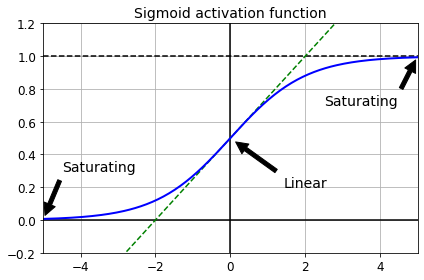

In [4]:
def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')

plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

로지스틱 활성화 함수를 보면 입력의 절대값이 커지면 0이나 1로 수렴해서 기울기가 0에 매우 가까워지는 것을 알 수 있다. 그래서 역전파를 수행할 때 전파할 그래디언트가 거의 없고 조금 있는 그래디언트는 최상위층에서 역전파가 진행되면서 서서히 약해지면서 사실상 아래쪽 층에는 아무 값도 도달하지 않게 된다.

### 글로럿과 He 초기화

글로럿과 벤지오는 불안정한 그래디언트 문제를 완화하는 방법을 제시했다.

예측을 할 때는 정방향으로, 그래디언트를 역전파할때는 역방향으로 양방향 신호가 적절히 흘러야 한다. 그러기 위해서는 신호가 사라지거나 폭주하지 않아야 한다.
- 이를 위해서는 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 한다고 주장했다.
- 그리고, 역방향에서 층을 통과하기 전과 후의 그래디언트 분산이 동일해야 한다.

이 때, 층의 입력과 출력 연결 개수(fan-in, fan-out)가 다르면 이 두 가지를 보장할 수 없다. 하지만 글로럿과 벤지오는 실전에서 매우 잘 작동한다고 입증된 대안을 제시했다. 
- 각 층의 연결 가중치를 아래와 같이 무작위로 초기화하는 것이다.

**글로럿 초기화**(로지스틱 활성화 함수를 사용할 때)
- 평균이 0이고 분산이 $\sigma^2 = \dfrac{1}{fan_{\text{avg}}}$인 정규분포
- 또는 $r = \sqrt{\dfrac{3}{fan_{\text{avg}}}}$일 때 $-r$과 $+r$ 사이의 균등분포

위의 식에서 $fan_{\text{avg}}$를 $fan_{\text{in}}$으로 바꾸면 1990년에 얀 르쿤이 제안한 초기화 전략이 되며, 이를 르쿤 초기화라고 부른다.

$fan_{\text{avg}} = fan_{\text{in}}$이면 르쿤 초기화는 글로럿 초기화와 동일하게 된다. 

**초기화 전략**

|초기화 전략|활성화 함수|$\sigma^2$|
|-----|:---|---|
|글로럿|활성화함수 없음, 하이퍼볼릭 탄젠트, 로지스틱, 소프트맥스|$\dfrac{1}{fan_{\text{avg}}}$|
|He|ReLU 함수와 ReLU함수의 변종|$\dfrac{2}{fan_{\text{in}}}$|
|르쿤|SELU|$\dfrac{1}{fan_{\text{in}}}$|

In [5]:
[name for name in dir(keras.initializers) if not name.startswith('_')]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

케라스는 기본적으로 uniform distribution의 글로럿 초기화를 사용한다. 층을 만들 때 `kernel_initializer = 'he_uniform'`이나 `kernel_initializer = 'he_normal'`로 바꾸어 He 초기화를 사용할 수도 있다.

In [6]:
keras.layers.Dense(10, activation = 'relu', kernel_initializer = 'he_normal')

$fan_{\text{in}}$ 대신 $fan_{\text{out}}$기반의 균등분포 He 초기화를 사용하고 싶다면 다음과 같이 `Variance Scaling`을 사용할 수 있다.

In [7]:
he_avg_init = keras.initializers.VarianceScaling(scale = 2., mode = 'fan_avg',
                                                 distribution = 'uniform')

keras.layers.Dense(10, activation = 'sigmoid', kernel_initializer = he_avg_init)

## 수렴하지 않는 활성화 함수 

글로럿과 벤지오의 2010년 논문에서의 통찰 중 하나는 활성화 함수를 잘못 선택하면 그래디언트 소실이나 폭주로 이어질 수 있다는 것이다. 그 전에는 생물학적 뉴런의 방식과 비슷한 시그모이드가 최선이라고 생각했지만 실제로 다른 함수가 훨씬 더 심층 신경망에서 잘 작동한다는 것이 밝혀졌다. 특히 ReLU는 특정 양수값에 수렴하지 않는다는 큰 장점이 있고 계산도 빠르다. 

하지만 ReLU도 완벽하지 않다.(죽은 ReLU 문제) 
- 훈련하는 동안 일부 뉴런이 0 이외의 값을 출력하지 않는다는 의미에서 죽었다고 표현한다. 
- 어떤 경우에는 큰 학습률을 사용하면 신경망의 뉴런 절반이 죽어있기도 한다. 
- 뉴런의 가중치가 바뀌어 훈련 세트에 있는 모든 샘플에 대해 입력의 가중치 합이 음수가 되면 뉴런이 죽게 된다. 
    - 가중치 합이 음수이면 ReLU함수의 그래디언트가 0이 되므로 경사하강법이 더 이상 진행되지 않는다. 
   
이러한 문제를 해결하기 위해 LeakyReLU와 같은 ReLU함수의 변종을 사용한다. 

$$\text{LeakyReLU}_{\alpha}(z) = \text{max}(\alpha z, z)$$로 정의된다.

이 때, $\alpha$가 새는(leaky) 정도를 결정한다. 이는 $z<0$일 때의 함수의 기울기이며, 일반적으로 0.01로 설정한다. 이렇게 되면 뉴런을 절대 죽지 않게 만들 수 있다. 

그림 저장: leaky_relu_plot


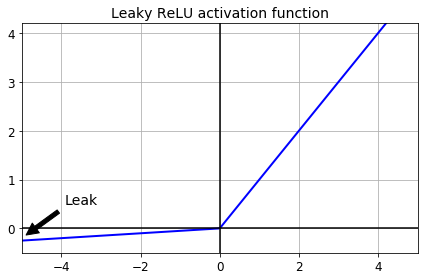

In [8]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
[name for name in dir(keras.activations) if not name.startswith('_')]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

LeakyReLU를 이용해 fashion MNIST에서 신경망 훈련

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full / 255.0
X_test = X_test / 255.0 

X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(300, kernel_initializer = 'he_normal'),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer = 'he_normal'),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation = 'softmax')
])

In [13]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = keras.optimizers.SGD(learning_rate = 1e-3),
              metrics = ['accuracy'])

In [14]:
history = model.fit(X_train, y_train, epochs = 10, 
                    validation_data = (X_valid, y_valid),)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 82us/sample - loss: 1.2806 - accuracy: 0.6250 - val_loss: 0.8883 - val_accuracy: 0.7152
Epoch 2/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.7954 - accuracy: 0.7374 - val_loss: 0.7135 - val_accuracy: 0.7648
Epoch 3/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.6816 - accuracy: 0.7727 - val_loss: 0.6356 - val_accuracy: 0.7882
Epoch 4/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.6215 - accuracy: 0.7936 - val_loss: 0.5922 - val_accuracy: 0.8012
Epoch 5/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.5830 - accuracy: 0.8082 - val_loss: 0.5596 - val_accuracy: 0.8172
Epoch 6/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5338 - val_accuracy: 0.8238
Epoch 7/10
55000/55000 [==============================] -

PReLU를 이용해 fashion MNIST에서 신경망 훈련

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 91us/sample - loss: 1.3470 - accuracy: 0.6225 - val_loss: 0.9268 - val_accuracy: 0.7200
Epoch 2/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.8209 - accuracy: 0.7357 - val_loss: 0.7322 - val_accuracy: 0.7640
Epoch 3/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.6972 - accuracy: 0.7697 - val_loss: 0.6494 - val_accuracy: 0.7866
Epoch 4/10
55000/55000 [==============================] - 4s 79us/sample - loss: 0.6332 - accuracy: 0.7904 - val_loss: 0.6027 - val_accuracy: 0.8024
Epoch 5/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.5918 - accuracy: 0.8051 - val_loss: 0.5675 - val_accuracy: 0.8140
Epoch 6/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.5619 - accuracy: 0.8140 - val_loss: 0.5393 - val_accuracy: 0.8252
Epoch 7/10
55000/55000 [==============================] -

**ELU**

마지막으로 툐르크-아르네 클레베르트(Djork-Ame Clevert)등의 2015년 논문은 **ELU**(Exponential linear unit)이라는 새로운 활성화 함수를 제안했다. 이 함수는 모든 ReLU의 변종의 성능을 앞질렀다. 훈련 시간이 줄고 신경망의 테스트 세트 성능도 증가했다.

$$\text{ELU}_{\alpha}(z) = \begin{cases}
\alpha(\text{exp}(z)-1), z<0 \\ 
z, z\ge0
\end{cases}$$로 정의된다.

이 함수는 ReLU와 매우 비슷하지만 다음의 몇 가지의 차이점이 있다.

- z<0 일 때 음수값이 들어오기 때문에 활성화 함수의 평균 출력이 0에 가까워진다. 이는 그래디언트 소실 문제를 완화해준다. 
- z<0 이어도 그래디언트가 0이 아니기 때문에 죽은 뉴런을 만들지 않는다. 
- $\alpha=1$이면 이 함수는 z=0에서 급격히 변동하지 않으므로 z=0을 포함해 모든 구간에서 매끄럽기 때문에 경사하강법의 속도를 높여준다.

ELU의 주요 단점은 지수함수를 사용하기 때문에 ReLU나 다른 변종에 비해 계산이 느리다는 것이다. 훈련하는 동안에는 수렴 속도가 빠르기 때문에 느린 계산이 상쇄되지만 테스트 시에는 ELU를 사용한 네트워크가 ReLU를 사용한 네트워크보다 느려진다. 

In [16]:
def elu(z, alpha = 1) : 
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

그림 저장: elu_plot


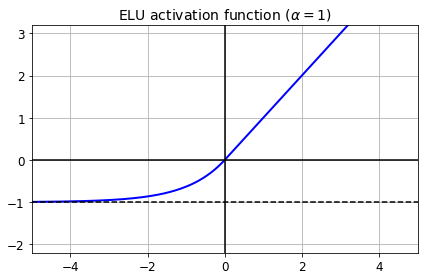

In [17]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

텐서플로에서 쉽게 ELU를 적용할 수 있다. 층을 만들 때 활성화 함수로 지정하면 된다.

In [18]:
keras.layers.Dense(10, activation = 'elu')

**SELU**

권터 클람바우어는 SELU(Scaled ELU)를 소개했다. (스케일이 조정된 ELU 활성화 함수의 변종)

연구진은 FC layer만 쌓아서 신경망을 구성하고 모든 은닉층이 SELU 활성화 함수를 사용하면 네트워크가 자기정규화된다는 것을 보였다. 즉, 훈련하는 동안 각 층의 출력이 평균 0과 표준편차 1을 유지하는 경향이 있다. 
- 이는 그래디언트 소실과 폭주 문제를 막아준다.

하지만 자기 정규화가 일어나기 위한 몇 가지 조건이 있다.
- 입력 특성이 반드시 표준화되어야 한다.
- 모든 은닉층의 가중치는 르쿤 정규분포 초기화로 초기화되어야 한다. 
    - 케라스에서는 `kernel_initializer=lecun_normal`로 설정
- 네트워크는 일렬로 쌓은 층으로 구성되어야 한다. RNN이나 skip connection(즉, wide&deep 네트워크에서 건너뛰어 연결된 층)과 같은 순차적이지 않은 구조에 SELU를 사용하면 자기정규화가 보장되지 않는다.

In [19]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) *\
(2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)


In [20]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

그림 저장: selu_plot


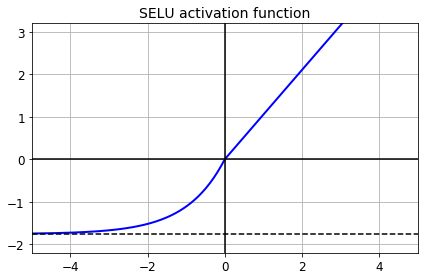

In [21]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

In [22]:
np.random.seed(42)

Z = np.random.normal(size = (500, 100))
for layer in range(1000) : 
    W = np.random.normal(size = (100, 100), scale = np.sqrt(1/100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis = 0).mean()
    stds = np.std(Z, axis = 0).mean()
    if layer % 100 == 0 : 
        print('layer {} : mean {:.2f}, std {:2f}'.format(layer, means, stds))

layer 0 : mean -0.00, std 0.999333
layer 100 : mean 0.02, std 0.962431
layer 200 : mean 0.01, std 0.904488
layer 300 : mean -0.02, std 0.923692
layer 400 : mean 0.05, std 0.891603
layer 500 : mean 0.01, std 0.928646
layer 600 : mean 0.02, std 0.916642
layer 700 : mean -0.02, std 0.903355
layer 800 : mean 0.05, std 0.825012
layer 900 : mean 0.02, std 0.995589


In [23]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

100개의 은닉층과 SELU 활성화 함수를 사용한 fashion MNIST 신경망

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation = 'selu', 
                             kernel_initializer = 'lecun_normal'))

for layer in range(99) : 
    model.add(keras.layers.Dense(100, activation = 'selu',
                                 kernel_initializer = 'lecun_normal'))
    
model.add(keras.layers.Dense(10, activation = 'softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = keras.optimizers.SGD(learning_rate = 1e-3),
              metrics = ['accuracy'])

훈련하기 전에 입력을 평균 0과 표준편차 1로 바꿔야 함.

In [25]:
pixel_means = X_train.mean(axis = 0, keepdims = True)
pixel_stds = X_train.std(axis = 0, keepdims = True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds


In [26]:
history = model.fit(X_train_scaled, y_train, epochs = 5,
                    validation_data = (X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 65s 1ms/sample - loss: 1.0585 - accuracy: 0.5893 - val_loss: 0.6899 - val_accuracy: 0.7546
Epoch 2/5
55000/55000 [==============================] - 63s 1ms/sample - loss: 0.6699 - accuracy: 0.7652 - val_loss: 0.6600 - val_accuracy: 0.7760
Epoch 3/5
55000/55000 [==============================] - 62s 1ms/sample - loss: 0.5659 - accuracy: 0.8060 - val_loss: 0.5700 - val_accuracy: 0.8064
Epoch 4/5
55000/55000 [==============================] - 61s 1ms/sample - loss: 0.5194 - accuracy: 0.8236 - val_loss: 0.5188 - val_accuracy: 0.8176
Epoch 5/5
55000/55000 [==============================] - 64s 1ms/sample - loss: 0.4777 - accuracy: 0.8353 - val_loss: 0.4691 - val_accuracy: 0.8388


ReLU함수를 이용해 학습

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation = 'relu', 
                             kernel_initializer = 'he_normal'))

for layer in range(99) : 
    model.add(keras.layers.Dense(100, activation = 'relu',
                                 kernel_initializer = 'he_normal'))
    
model.add(keras.layers.Dense(10, activation = 'softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = keras.optimizers.SGD(learning_rate = 1e-3),
              metrics = ['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs = 5,
                    validation_data = (X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 32s 578us/sample - loss: 1.7940 - accuracy: 0.2739 - val_loss: 1.1652 - val_accuracy: 0.5412
Epoch 2/5
55000/55000 [==============================] - 32s 576us/sample - loss: 1.1181 - accuracy: 0.5403 - val_loss: 1.0631 - val_accuracy: 0.6040
Epoch 3/5
55000/55000 [==============================] - 34s 615us/sample - loss: 0.9124 - accuracy: 0.6366 - val_loss: 0.7725 - val_accuracy: 0.7020
Epoch 4/5
55000/55000 [==============================] - 33s 607us/sample - loss: 0.8735 - accuracy: 0.6489 - val_loss: 0.7368 - val_accuracy: 0.7086
Epoch 5/5
55000/55000 [==============================] - 34s 612us/sample - loss: 0.7181 - accuracy: 0.7219 - val_loss: 0.6821 - val_accuracy: 0.7304


## 배치 정규화

ELU나 다른 ReLU의 변종과 함께 He 초기화를 사용하면 훈련 초기에 그래디언트 소실이나 폭주 문제를 크게 감소시킬 수 있지만 여전히 훈련하는 동안 다시 발생할 수 있다. 

2015년에 세르게이 이오페와 치리슈티언 세게지가 그래디언트 소실과 폭주 문제를 해결하기 위한 배치 정규화(Batch Normalization, BN) 기법을 제안했다. 이 기법은 각 층에서 활성화 함수를 통과하기 전이나 후에 모델에 연산을 하나 추가한다.
- 단순히 입력을 원점에 맞추고 정규화한 다음 각 층에서 두 개의 새로운 파라미터로 결과값의 스케일을 조정하고 이동시킨다.
    - 하나는 스케일, 하나는 이동에 사용한다.
  
많은 경우 신경망의 첫 번째 층으로 배치 정규화를 추가하면 훈련 세트를 표준화할 필요가 없다. 배치 정규화 층이 이러한 역할을 대신한다. 

입력 데이터를 원점에 맞추고 정규화하려면 알고리즘은 평균과 표준편차를 추정해야 한다. 이를 위해 현재 미니배치에서 입력의 평균과 표준편차를 계산한다. 

**배치 정규화 알고리즘**

1.$\mu_{B}=\dfrac{1}{m_\text{B}} \sum_{i=1}^{m_\text{B}}\mathbf{x}^{(i)}$

2.${\sigma_\text{B}}^2=\dfrac{1}{m_\text{B}}\sum_{i=1}^{m_\text{B}}(\mathbf{x}^{(i)}-\mu_\text{B})^2$

3.$\hat{{\mathbf{x}}}^{(i)}=\dfrac{\mathbf{x}^{(i)}-\mu_\text{B}}{\sqrt{{\sigma_B}^2+\epsilon}}$

4.$\mathbf{z}^{(i)}=\gamma\bigotimes\hat{\mathbf{x}}^{(i)}+\beta$


In [28]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation = 'softmax'),
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

In [29]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

배치 정규화 층은 입력마다 네 개의 파라미터 $\gamma, \beta, \mu, \sigma$를 추가한다. 이 때 $\mu, \sigma$는 학습되지 않기 때문에 Non-trainable params로 분류한다.
- 전체 파라미터는 3136+1200+400 = 4736
- 이를 2로 나누면 Non-trainable params 2368이 계산된다.

In [30]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [31]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 117us/sample - loss: 0.8767 - accuracy: 0.7137 - val_loss: 0.5531 - val_accuracy: 0.8206
Epoch 2/10
55000/55000 [==============================] - 6s 105us/sample - loss: 0.5755 - accuracy: 0.8019 - val_loss: 0.4758 - val_accuracy: 0.8460
Epoch 3/10
55000/55000 [==============================] - 6s 108us/sample - loss: 0.5154 - accuracy: 0.8212 - val_loss: 0.4397 - val_accuracy: 0.8536
Epoch 4/10
55000/55000 [==============================] - 6s 105us/sample - loss: 0.4842 - accuracy: 0.8311 - val_loss: 0.4162 - val_accuracy: 0.8592
Epoch 5/10
55000/55000 [==============================] - 6s 105us/sample - loss: 0.4560 - accuracy: 0.8422 - val_loss: 0.4002 - val_accuracy: 0.8652
Epoch 6/10
55000/55000 [==============================] - 6s 105us/sample - loss: 0.4400 - accuracy: 0.8469 - val_loss: 0.3883 - val_accuracy: 0.8698
Epoch 7/10
55000/55000 [===========================

배치 정규화 층은 입력마다 이동 파라미터를 포함하기 때문에 이전 층에서 편향을 뺄 수 있다.(층을 만들 때 use_bias = False로 설정) 

In [32]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 126us/sample - loss: 1.0323 - accuracy: 0.6754 - val_loss: 0.6734 - val_accuracy: 0.7840
Epoch 2/10
55000/55000 [==============================] - 6s 105us/sample - loss: 0.6778 - accuracy: 0.7816 - val_loss: 0.5572 - val_accuracy: 0.8198
Epoch 3/10
55000/55000 [==============================] - 6s 106us/sample - loss: 0.5923 - accuracy: 0.8049 - val_loss: 0.5003 - val_accuracy: 0.8346
Epoch 4/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.5449 - accuracy: 0.8167 - val_loss: 0.4668 - val_accuracy: 0.8436
Epoch 5/10
55000/55000 [==============================] - 6s 105us/sample - loss: 0.5117 - accuracy: 0.8269 - val_loss: 0.4432 - val_accuracy: 0.8516
Epoch 6/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.4886 - accuracy: 0.8353 - val_loss: 0.4278 - val_accuracy: 0.8548
Epoch 7/10
55000/55000 [===========================

## 그래디언트 클리핑

그래디언트 폭주 문제를 완화하는 다른 방법은 역전파 때 일정 임계값을 넘어서지 못하게 그래디언트를 잘라내는 것이다. 이를 그래디언트 클리핑(gradient clipping)이라고 한다. 
- 순환 신경망의 경우 배치 정규화를 적용하기 어렵기 때문에 그래디언트 클리핑을 많이 사용한다. 

```python
optimizer = keras.optimizers.SGD(clipvalue = 1.0)
model.compile(loss = 'mse')
```

이 옵티마이저는 그래디언트 벡터의 모든 원소를 -1과 1 사이로 클리핑한다. 이 기능은 그래디언트 벡터의 방향을 바꿀 수 있다.
- 예를 들면, 원래 그래디언트 벡터가 [0.9, 100]일 때 대부분 두 번째 축 방향을 향한다. 하지만 클리핑을 수행하면 [0.9, 1]이 되고 거의 대각선 방향을 향하게 된다. 
- 실전에는 이 방법이 잘 작동한다. 
- 만약 그래디언트 클리핑이 벡터의 방향을 바꾸지 못하게 하려면 `clipvalue` 대신 `clipnorm`을 지정하여 norm으로 클리핑 해야한다. 
    - 예를 들어 `clipnorm=1.0`으로 지정하면 벡터 [0.9, 100]이 [0.00899964, 0.9999595]로 클리핑되기 때문에 방향을 유지한다. 하지만 첫 번째 원소는 거의 무시된다.
    
- 훈련 과정에서 그래디언트가 폭주한다면 다른 임계값으로 클리핑할 수 있다.

# 사전훈련된 층 재사용하기

일반적으로 아주 큰 규모의 DNN을 처음부터 새로 훈련하는 것은 좋은 방법이 아니다. 해결하려는 문제와 비슷한 문제를 처리한 신경망이 있는지 찾아본 다음 그 신경망의 하위층을 재사용하는 것이 좋다. 이를 전이학습(transfer learning)이라고 한다. 
- 이 방법은 훈련 속도를 크게 높일 뿐만 아니라 필요한 훈련 데이터도 크게 줄여준다. 

동물, 식물, 자동차, 생활용품을 포함한 100개의 카테고리로 구분된 이미지를 분류하도록 훈련한 DNN을 가지고 있다고 가정해보자. 이 때, 구체적인 자동차의 종류를 분류하는 DNN을 훈련하려고 할 때, 이 작업들은 비슷한 점이 많고 일부 겹치기도 하기 때문에 첫 번째 신경망의 일부를 재사용할 필요가 있다.

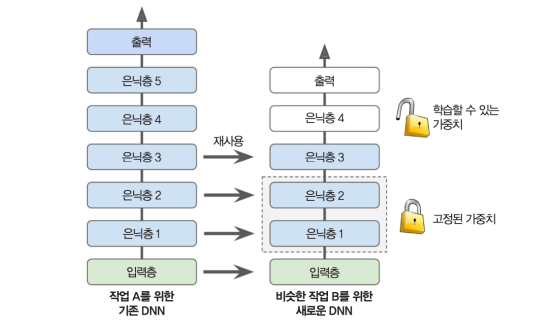

만약 원래 문제에서 사용한 이미지와 크기가 다른 이미지를 입력으로 사용할 때는 원본 모델에 맞는 이미지 크기로 바꿔주는 전처리 단계가 필요하다. 일반적으로 전이학습은 저수준 특성이 비슷한 입력에서 잘 작동한다.

보통 원본 모델의 출력층을 바꿔야 한다. 기존의 출력층은 새로운 작업의 목적에 있어 유용하지 않은 층이고 새로운 작업의 출력 개수와 맞지 않을 수도 있다. 비슷한 원리로 원본 모델의 상위 은닉층은 하위 은닉층보다 덜 유용하다. 새로운 작업에 유용한 고수준 특성은 원본 작업에서 작업했던 유용한 특성과는 상당히 다르기 때문이다. 따라서 몇 개의 층을 사용할지 잘 선택해야 한다. 

먼저 재사용하는 층을 모두 동결한다.(즉, 경사 하강법으로 가중치가 바뀌지 않도록 훈련되지 않는 가중치로 만든다.) 그 후에 모델을 훈련하고 성능을 측정한다. 맨 위에 있는 한두개의 은닉층의 동결을 해제하고 역전파를 통해 가중치를 조정하여 성능이 확인되는지 확인한다.  훈련 데이터가 많을수록 많은 층의 동결을 해제할 수 있다. 
- 재사용 층의 동결을 해제할 때는 학습률을 줄이는 것이 가중치를 세밀하게 튜닝하는 데 도움이 되기 때문에 좋다.

여전히 성능이 좋지 않고 훈련 데이터가 적다면 상위 은닉층을 제거하고 남은 은닉층을 다시 동결해본다. 이런 식으로 적절한 개수의 은닉층을 찾을 때까지 반복한다. 훈련 데이터가 아주 많다면 은닉층을 제거하는 대신 다른 것으로 바꾸거나 더 추가할 수도 있다.

## 케라스를 사용한 전이학습

예) 8개의 클래스만 있는 fashion MNIST 데이터셋이 있다고 가정해보자. 이 데이터셋에는 샌들과 셔츠를 제외한 다른 클래스가 있다. 누군가 이 클래스를 분류하는 작업 A를 해결하는 모델을 만들어 꽤 좋은 성능(90%이상의 정확도)을 얻었다. 이를 **모델A**라고 하자.

샌들과 셔츠 이미지를 구분하는 작업 B를 해결하기 위해 이진 분류기를 훈련하려 한다.(양성=셔츠, 음성=샌들). 레이블된 이미지는 고작 200개로 매우 적다. 이를 위해 모델 A와 구조가 거의 비슷한 **모델B**라는 새 모델을 만들었다. 모델 B는 꽤 좋은 성능(97.2%의 정확도) 하지만 모델B는 클래스가 2개 뿐인 쉬운 문제이므로 성능을 더 올리고 싶다. 이 때 작업 B는 작업 A와 매우 비슷하다는 것을 깨달았을 때, 혹시 전이 학습이 도움이 될 수 있을까?

모델 A와 모델 B 생성

In [33]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [34]:
print(X_train_A.shape)
print(X_train_B.shape)

(43986, 28, 28)
(200, 28, 28)


In [35]:
tf.random.set_seed(42)
np.random.seed(42)

model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/20
43986/43986 [==============================] - 5s 113us/sample - loss: 0.5909 - accuracy: 0.8100 - val_loss: 0.3771 - val_accuracy: 0.8712
Epoch 2/20
43986/43986 [==============================] - 4s 95us/sample - loss: 0.3521 - accuracy: 0.8794 - val_loss: 0.3395 - val_accuracy: 0.8777
Epoch 3/20
43986/43986 [==============================] - 5s 106us/sample - loss: 0.3167 - accuracy: 0.8890 - val_loss: 0.3017 - val_accuracy: 0.8961
Epoch 4/20
43986/43986 [==============================] - 5s 103us/sample - loss: 0.2970 - accuracy: 0.8967 - val_loss: 0.2858 - val_accuracy: 0.9028
Epoch 5/20
43986/43986 [==============================] - 5s 105us/sample - loss: 0.2824 - accuracy: 0.9030 - val_loss: 0.2806 - val_accuracy: 0.9063
Epoch 6/20
43986/43986 [==============================] - 5s 109us/sample - loss: 0.2721 - accuracy: 0.9072 - val_loss: 0.2684 - val_accuracy: 0.9103
Epoch 7/20
43986/43986 [============================

In [36]:
model_A.save("my_model_A.h5")

In [37]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape = [28, 28]))
for n_hidden in (300, 100, 50, 50, 50) : 
    model_B.add(keras.layers.Dense(n_hidden, activation = 'selu'))
model_B.add(keras.layers.Dense(1, activation = 'sigmoid'))

model_B.compile(loss = 'binary_crossentropy',
                optimizer = keras.optimizers.SGD(learning_rate = 1e-3),
                metrics = ['accuracy'])

history = model_B.fit(X_train_B, y_train_B, epochs = 20,
                      validation_data = (X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/20
200/200 [==============================] - 1s 4ms/sample - loss: 0.9545 - accuracy: 0.4600 - val_loss: 0.6655 - val_accuracy: 0.5385
Epoch 2/20
200/200 [==============================] - 0s 734us/sample - loss: 0.5899 - accuracy: 0.6900 - val_loss: 0.4785 - val_accuracy: 0.8519
Epoch 3/20
200/200 [==============================] - 0s 624us/sample - loss: 0.4512 - accuracy: 0.8800 - val_loss: 0.4098 - val_accuracy: 0.8945
Epoch 4/20
200/200 [==============================] - 0s 524us/sample - loss: 0.3871 - accuracy: 0.9100 - val_loss: 0.3666 - val_accuracy: 0.9128
Epoch 5/20
200/200 [==============================] - 0s 613us/sample - loss: 0.3438 - accuracy: 0.9250 - val_loss: 0.3315 - val_accuracy: 0.9300
Epoch 6/20
200/200 [==============================] - 0s 664us/sample - loss: 0.3095 - accuracy: 0.9300 - val_loss: 0.3034 - val_accuracy: 0.9402
Epoch 7/20
200/200 [==============================] - 0s 568us/sample - loss: 0.

In [38]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_224 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_225 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_226 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_227 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_228 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_229 (Dense)            (None, 1)                

모델 A를 로드하고 이 모델의 층을 기반으로 세로운 모델(**model_B_on_A**)을 생성

```python
model_A = keras.models.load_model('my_model_A.h5')
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation = 'sigmoid'))
```
위와 같이 훈련하면 `model_B_on_A`와 `model_A`는 같은 층을 공유하기 때문에 두 모델이 업데이트 된다. 이를 방지하기 위해 `model_A`를 클론한 것을 사용해 `model_B_on_A`를 만들어야 한다.

In [39]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

처음 몇 번의 에포크동안은 출력층이 랜덤하게 초기화되어있기 때문에 큰 오차가 발생한다. 큰 오차가 재사용된 가중치를 망칠 수 있다. 이를 막기 위한 한 가지 방법은 처음 몇 번의 에포크동안 재사용된 층을 동결하고 새로운 층에게 적절한 가중치를 학습할 시간을 주는 것이다.

In [40]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 1s 3ms/sample - loss: 0.5783 - accuracy: 0.6500 - val_loss: 0.5792 - val_accuracy: 0.6460
Epoch 2/4
200/200 [==============================] - 0s 579us/sample - loss: 0.5405 - accuracy: 0.7000 - val_loss: 0.5450 - val_accuracy: 0.6795
Epoch 3/4
200/200 [==============================] - 0s 494us/sample - loss: 0.5067 - accuracy: 0.7150 - val_loss: 0.5147 - val_accuracy: 0.7160
Epoch 4/4
200/200 [==============================] - 0s 476us/sample - loss: 0.4768 - accuracy: 0.7550 - val_loss: 0.4855 - val_accuracy: 0.7302


In [41]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 1s 4ms/sample - loss: 0.3950 - accuracy: 0.8250 - val_loss: 0.3376 - val_accuracy: 0.8722
Epoch 2/16
200/200 [==============================] - 0s 600us/sample - loss: 0.2746 - accuracy: 0.9250 - val_loss: 0.2608 - val_accuracy: 0.9270
Epoch 3/16
200/200 [==============================] - 0s 509us/sample - loss: 0.2105 - accuracy: 0.9650 - val_loss: 0.2149 - val_accuracy: 0.9523
Epoch 4/16
200/200 [==============================] - 0s 528us/sample - loss: 0.1707 - accuracy: 0.9750 - val_loss: 0.1804 - val_accuracy: 0.9645
Epoch 5/16
200/200 [==============================] - 0s 544us/sample - loss: 0.1412 - accuracy: 0.9800 - val_loss: 0.1573 - val_accuracy: 0.9757
Epoch 6/16
200/200 [==============================] - 0s 624us/sample - loss: 0.1212 - accuracy: 0.9900 - val_loss: 0.1395 - val_accuracy: 0.9817
Epoch 7/16
200/200 [==============================] - 0s 614us/sample - loss: 0.

In [42]:
model_B.evaluate(X_test_B, y_test_B, verbose = 0)

[0.14446662020683287, 0.9695]

In [43]:
model_B_on_A.evaluate(X_test_B, y_test_B, verbose = 0)

[0.06896587526798248, 0.9925]

In [44]:
(100 - 96.95) / (100 - 99.25)

4.066666666666663

실제로 전이학습은 작은 완전 연결 네트워크에서는 잘 동작하지 않는다. 
- 작은 네트워크는 패턴 수를 적게 학습하고 완전 연결 네트워크는 특정 패턴을 학습할 것이기 때문

전이 학습은 조금 더 일반적인 특성(특히 아래쪽 층에서) 감지하는 경향이 있는 심층 합성곱 신경망에서 잘 동작한다. 

## 비지도 사전 훈련

레이블된 훈련 데이터가 많지 않은 상태에서 비슷한 작업에 대해 훈련된 모델마저 찾을 수 없는 상황을 가정해보자. 
이 때 가장 먼저 시도할 수 있는 방법은 레이블된 훈련 데이터를 더 모으는 것이다. 만약 이것이 어렵다면 **비지도 사전 훈련**을 수행할 수 있다. 

레이블이 없는 훈련 데이터를 모으는 것은 비용이 적게 들지만 레이블을 부여하는 과정이 비용이 많이 든다. 
레이블되지 않은 훈련 데이터를 많이 모을 수 있다면 이를 이용하여 오토인코더나 GAN같은 비지도 학습 모델을 훈련할 수 있다. 그 다음 오토인코더나 GAN 판별자의 하위층을 재사용하고 그 위에 새로운 작업에 맞는 출력층을 추가할 수 있다. 그 다음 지도학습으로(레이블된 훈련 샘플로) 최종 네트워크를 세밀하게 튜닝한다. 



## 보조 작업에서 사전 훈련 

레이블된 훈련 데이터가 많지 않다면 마지막 선택 사항은 레이블된 훈련 데이터를 쉽게 얻거나 생성할 수 있는 보조 작업에서 첫 번째 신경망을 훈련하는 것이다. 그리고 이 신경망의 하위층을 실제 작업을 위해 재사용한다. 첫 번째 신경망의 하위층은 두 번째 신경망에 재사용될 수 있는 특성 추출기를 학습하게 된다. 

예를 들어 얼굴을 인식하는 시스템을 만들려고 하는데 개인별 이미지가 얼마 없다면 좋은 분류기를 훈련하기에 충분하지 않다. 각 사람의 사진을 수백 개씩 모으기는 현실적으로 어렵다. 그러나 인터넷에서 무작위로 많은 인물의 이미지를 수집해서 두 개의 다른 이미지가 같은 사람의 것인지 감지하는 첫 번째 신경망을 훈련할 수 있다. 이런 신경망은 얼굴의 특성을 잘 감지하도록 학습된다. 이런 신경망의 하위층을 이용해서 적은 양의 훈련 데이터에서 얼굴을 잘 구분하는 분류기를 학습할 수 있다. 


**NLP** 애플리케이션에서는 수백만 개의 텍스트 문서로 이루어진 코퍼스를 다운로드하고 이 데이터에서 레이블된 데이터를 자동으로 생성할 수 있다. 예를 들어 일부 단어를 랜덤하게 지우고 누락된 단어를 예측하는 모델을 훈련할 수 있다.
- What ___ you saying? 이라는 문장이 있으면 are 또는 were로 예측해야 한다. 

이 작업에서 좋은 성능을 내는 모델을 훈련할 수 있다면 이 모델은 언어에 대해서 상당히 많은 것을 알고 있는 모델이다. 실제 작업에 이 모델을 재사용하고 레이블된 데이터를 활용하여 세부 튜닝할 수 있다.

# 고속 옵티마이저

아주 큰 심층 신경망의 속도는 심각하게 느릴 수 있다. 지금까지 훈련 속도를 높이는 4가지 방법을 알아보았다.
- 연결 가중치에 좋은 초기화 전략 사용하기
- 좋은 활성화 함수 사용하기
- 배치 정규화 사용하기
- 사전 훈련된 네트워크의 일부를 재사용하기 

훈련 속도를 높일 수 있는 또 다른 방법으로 표준적인 경사 하강법 대신 더 빠른 옵티마이저를 사용하는 것이 있다. 
- 모멘텀 최적화
- 네스테로프 가속 경사
- AdaGrad
- RMSProp
- Adam
- Nadam

## 모멘텀 최적화

볼링공이 매끈한 표면의 완만한 경사를 따라 굴러간다고 해보자. 처음에는 느리게 출발하지만 종단속도에 도달할 때까지는 빠르게 가속된다. 
이것이 보리스 폴랴크가 제안한 모멘텀 최적화의 간단한 원리이다. 반대로 표준적인 경사 하강법은 경사면을 따라 일정한 크기의 스텝으로 조금씩 내려가기 때문에 맨 아래에 도착하는 데 시간이 더 오래 걸린다. 

경사 하강법은 가중치에 대한 비용 함수 $J(\theta)$의 그래디언트 $\nabla_\theta J(\theta)$에 학습률 $\eta$를 곱한 것을 바로 차감하여 가중치 $\theta$를 갱신한다. 공식은 $$\theta \leftarrow \theta - \eta \nabla_\theta J(\theta)$$

이다. 이 식은 이전 그래디언트가 얼마였는지 고려하지 않는다. 국부적으로 그래디언트가 아주 작으면 매우 느려진다. 

모멘텀 최적화는 이전 그래디언트가 얼마였는지를 중요하게 생각한다. 매 반복에서 현재 그래디언트를 학습률 $\eta$를 곱한 후에 모멘텀 벡터에 더하고 이 값을 빼는 방식으로 가중치를 갱신한다. 다시 말해 그래디언트를 속도가 아닌 가속도로 사용한다. 일종의 마찰 저항을 표현하고 모멘텀이 너무 커지는 것을 막기 위해 모멘텀이라는 새로운 하이퍼파라미터 $\beta$가 등장한다. 이 값은 높은 마찰의 경우 0, 마찰 저항이 없는 경우 1이며 이 사이로 설정되어야 한다. 일반적으로 0.9를 사용한다.

1. $m \leftarrow \beta m - \eta \nabla_\theta J(\theta)$
2. $\theta \leftarrow \theta + m$

그래디언트가 일정하면 종단속도는 학습률 $\eta$를 곱한 그래디언트에 $\dfrac{1}{1-\beta}$를 곱한 것과 같음을 알 수 있다. 예를 들어 $\beta = 0.9$면 모멘텀 최적화가 경사 하강법보다 10배 빠르게 진행된다. 

모멘텀 최적화의 단점은 하이퍼 파라미터의 개수가 하나 늘어난다는 것이지만, 실제로 모멘텀 0.9에서 보통 잘 작동하며 경사 하강법보다 거의 항상 더 빠르다. 

모멘텀 최적화 구현
```python
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
```

## 네스테로프 가속 경사

네스테로프 가속 경사는 기본 모멘텀 최적화보다 거의 항상 더 빠르다. 이는 현재 위치가 $\theta$가 아니라 모멘텀의 방향으로 조금 앞선 $\theta+\beta m$에서 비용 함수의 그래디언트를 계산하는 것이다. 

1. $m \leftarrow \beta m - \eta \nabla_\theta J(\theta+\beta m)$
2. $\theta \leftarrow \theta + m$

일반적으로 모멘텀 벡터가 최적점을 향하는 방향을 향하고 있을 것이므로 이런 변경이 가능하다. 

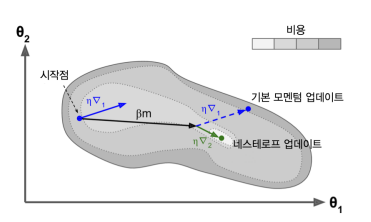

위의 그림처럼 원래 위치에서의 그래디언트를 사용하는 것보다 그 방향으로 조금 더 나아가서 측정한 그래디언트를 이용하는 것이 조금 더 정확할 것이다. ($\nabla_1$은 $\theta$에서, $\nabla_2$는 $\theta+\beta m$에서 측정한 그래디언트

네스테로프 가속 경사 구현
```python
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov = True)
```

## AdaGrad

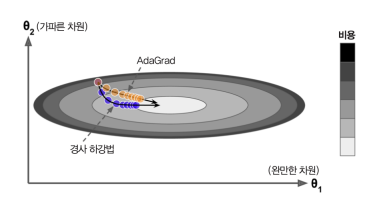

스케일이 달라서 한 쪽이 길쭉한 그릇의 형태가 되는 문제를 생각해보자. 경사 하강법은 가장 가파른 경사를 따라 빠르게 내려가서 골짜기 아래로 느리게 이동한다. 알고리즘이 이를 일직 감지하고 전역 최적점 쪽으로 좀 더 정확하게 방향을 잡는 것이 좋다.

AdaGrad 알고리즘은 가장 가파른 차원을 따라 그래디언트 벡터의 스케일을 감소시켜 이 문제를 해결한다.

1. $s \leftarrow s + \nabla_\theta J(\theta) \bigotimes \nabla_\theta J(\theta)$
2. $\theta \leftarrow \theta - \eta \nabla_\theta J(\theta) ⊘ \sqrt{s+\epsilon}$

그래디언트의 제곱을 벡터 $s$에 누적한 다음 두 번째 단계에서 경사하강법을 수행한다. 이 때 그래디언트 벡터를 $sqrt{s+\epsilon}$으로 나누어 스케일을 조정한다. 학습률을 감소시키지만 경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소한다.

간단한 2차방정식 문제에서는 잘 작동하지만 신경망을 훈련할 때 너무 일찍 멈추는 경우가 종종 있다는 장점이 존재한다. 

AdaGrad 구현
```python
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)
```

## RMSProp
AdaGrad는 너무 빨리 느려져서 전역 최적점에 수렴하지 못하는 위험이 있다. RMSProp은 가장 최근 반복에서 비롯된 그래디언트만 누적함으로써 이 문제를 해결했다. 

1. $s \leftarrow \beta s + (1- \beta)\nabla_\theta J(\theta) \bigotimes \nabla_\theta J(\theta)$
2. $\theta \leftarrow \theta - \eta \nabla_\theta J(\theta) ⊘ \sqrt{s+\epsilon}$

아주 간단한 문제를 제외하고는 이 옵티마이저가 언제나 AdaGrad보다 성능이 좋기 때문에 Adam 최적화가 나오기 전까지는 연구자들이 가장 선호하는 알고리즘이었다.

RMSProp 구현
```python
.optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
```

## Adam과 Nadam 최적화

적응적 모멘트 추정(Adaptive Moment Estimation)을 의미하는 Adam은 모멘텀 최적화와 RMSProp의 아이디어를 합친 것이다. 모멘텀 최적화처럼 지난 그래디언트의 지수 감소 평균을 따르고 RMSProp처럼 지난 그래디언트 지수 감소된 평균을 따른다. 

1. $m \leftarrow \beta_1 m - (1- \beta_1)\nabla_\theta J(\theta) $
2. $s \leftarrow \beta_2 s + (1- \beta_2)\nabla_\theta J(\theta) \bigotimes \nabla_\theta J(\theta)$
3. $\hat{m} \leftarrow \dfrac{m}{1-\beta^{t}_1}$
4. $\hat{s} \leftarrow \dfrac{s}{1-\beta^{t}_2}$
5. $\theta \leftarrow \theta + \eta \hat{m}⊘ \sqrt{\hat{s}+\epsilon}$



Adam 옵티마이저 구현
```python
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
```

**Nadam**

Adam 옵티마이저에 네스테로프 기법을 더한 것이다. 따라서 종종 Adam보다 빠르게 수렴한다.

Nadam 옵티마이저 구현
```python
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
```

|클래스|수렴 속도|수렴 품질|
|---|---|---|
|SGD|*|***|
|SGD(momentum = ...)|**|***|
|SGD(momentum = ..., nesterov = True)|**|***|
|Adagrad|***|*(너무 일찍 중단)|
|RMSProp|***|** 또는***|
|Adam|***|** 또는***|
|Nadam|***|** 또는***|
|AdaMax|***|** 또는***|


## 학습률 스케줄링

좋은 학습률을 찾는 것이 매우 중요하다. 학습률이 너무 큰 경우 훈련이 발산할 수 있다. 너무 작은 경우 수렴은 하겠지만 시간이 매우 오래 걸린다. 조금 크게 잡으면 처음에는 빠르게 훈련이 진행되지만 최적점 근처에서는 요동치면서 수렴하지 못 할 수 있다. 컴퓨팅 자원이 한정적이라면 차선의 솔루션을 만들기 위해 완전히 수렴하기 전에 훈련을 멈추어야 한다. 

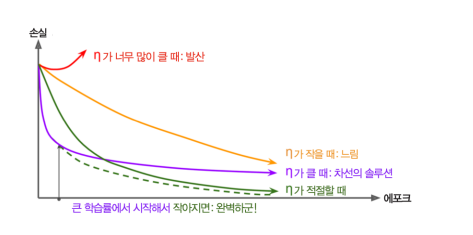

매우 작은 값에서 매우 큰 값까지 지수적으로 학습률을 증가시키면서 모델 훈련을 수백 번 반복하여 좋은 학습률을 찾을 수 있지만 더 나은 방법이 있다. 큰 학습률로 시작해서 학습 속도가 느려질 때 학습률을 낮추면 최적의 고정 학습률보다 좋은 솔루션을 더 빨리 발견할 수 있다. 이런 전략을 **학습 스케줄**이라고 한다. 

**거듭제곱 기반 스케줄링**
학습률을 반복 횟수 t에 대한 함수 $\eta(t)=\eta_0 / (1+t/s)^c$로 초기 학습률 $\eta_0$, 거듭제곱 수 $c$(일반적으로 1), 스텝 횟수 $s$는 하이퍼 파라미터이다. 학습률은 각 스텝마다 감소된다. $s$번 스텝 후에 학습률은 $\eta_0 /2$로 줄어든다. $s$번 스텝이 더 진행된 후에는 학습률이 $\eta_0/3$으로 줄어드는 식으로 감소한다. 처음에는 빠르게 감소하다가 점점 더 느리게 감소한다. 

In [49]:
optimizer = keras.optimizers.SGD(learning_rate = 0.01, decay = 1e-4)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(300, activation = 'selu', kernel_initializer = 'lecun_normal'),
    keras.layers.Dense(100, activation = 'selu', kernel_initializer = 'lecun_normal'),
    keras.layers.Dense(10, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

n_epochs = 25 
history = model.fit(X_train_scaled, y_train, epochs = n_epochs,
                    validation_data = (X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 91us/sample - loss: 0.4875 - accuracy: 0.8287 - val_loss: 0.4052 - val_accuracy: 0.8632
Epoch 2/25
55000/55000 [==============================] - 4s 80us/sample - loss: 0.3814 - accuracy: 0.8658 - val_loss: 0.3917 - val_accuracy: 0.8632
Epoch 3/25
55000/55000 [==============================] - 4s 81us/sample - loss: 0.3479 - accuracy: 0.8766 - val_loss: 0.3629 - val_accuracy: 0.8710
Epoch 4/25
55000/55000 [==============================] - 4s 81us/sample - loss: 0.3266 - accuracy: 0.8842 - val_loss: 0.3525 - val_accuracy: 0.8764
Epoch 5/25
55000/55000 [==============================] - 4s 80us/sample - loss: 0.3109 - accuracy: 0.8903 - val_loss: 0.3435 - val_accuracy: 0.8806
Epoch 6/25
55000/55000 [==============================] - 4s 81us/sample - loss: 0.2978 - accuracy: 0.8949 - val_loss: 0.3427 - val_accuracy: 0.8810
Epoch 7/25
55000/55000 [==============================] -

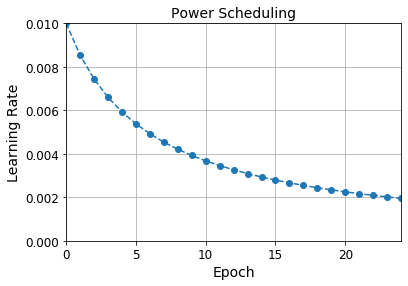

In [55]:
import math 

learning_rate = 0.01 
decay = 1e-4
batch_size = 32 
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs, 'o--')
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Power Scheduling', fontsize = 14)
plt.grid(True)
plt.show()

**지수 기반 스케줄링**

학습률을 $\eta(t)= \eta_0 {0.1}^{t/s}$로 설정한다. $s$ 스텝마다 10배씩 점차 줄어든다.

In [61]:
def exponential_decay(lr0, s) : 
    def exponential_decay_fn(epoch) : 
        return 0.01 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0 = 0.01, s = 20)

In [62]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(300, activation = 'selu', kernel_initializer = 'lecun_normal'),
    keras.layers.Dense(100, activation = 'selu', kernel_initializer = 'lecun_normal'),
    keras.layers.Dense(10, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])

n_epochs = 25 
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs = n_epochs,
                    validation_data = (X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 115us/sample - loss: 0.8587 - accuracy: 0.7541 - val_loss: 0.7588 - val_accuracy: 0.7654
Epoch 2/25
55000/55000 [==============================] - 6s 100us/sample - loss: 0.6871 - accuracy: 0.7942 - val_loss: 0.7926 - val_accuracy: 0.7930
Epoch 3/25
55000/55000 [==============================] - 5s 100us/sample - loss: 0.6362 - accuracy: 0.8088 - val_loss: 0.6735 - val_accuracy: 0.8104
Epoch 4/25
55000/55000 [==============================] - 5s 100us/sample - loss: 0.5552 - accuracy: 0.8307 - val_loss: 0.5272 - val_accuracy: 0.8158
Epoch 5/25
55000/55000 [==============================] - 6s 100us/sample - loss: 0.4942 - accuracy: 0.8439 - val_loss: 0.5152 - val_accuracy: 0.8494
Epoch 6/25
55000/55000 [==============================] - 5s 99us/sample - loss: 0.4520 - accuracy: 0.8584 - val_loss: 0.5240 - val_accuracy: 0.8466
Epoch 7/25
55000/55000 [============================

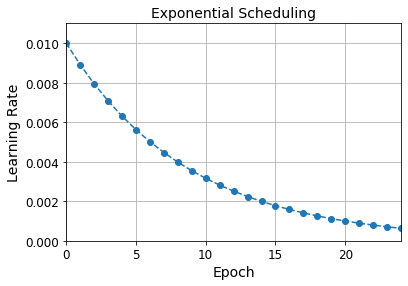

In [64]:
plt.plot(history.epoch, history.history["lr"], "o--")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

지수 기반 스케줄링 함수는 두 번째 매개변수로 현재 학습률을 받을 수 있다.

In [66]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

에포크가 아니라 반복마다 학습률을 업데이트하려면 사용자 정의 콜백 클래스를 작성해야 한다.

In [67]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # 에포크마다 `batch` 매개변수가 재설정된다
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # 20 에포크 동안 스텝 횟수 (배치 크기 = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 7s 130us/sample - loss: 0.8089 - accuracy: 0.7667 - val_loss: 0.6506 - val_accuracy: 0.8044
Epoch 2/25
55000/55000 [==============================] - 6s 112us/sample - loss: 0.6146 - accuracy: 0.8110 - val_loss: 0.6566 - val_accuracy: 0.8038
Epoch 3/25
55000/55000 [==============================] - 6s 112us/sample - loss: 0.6009 - accuracy: 0.8216 - val_loss: 0.6280 - val_accuracy: 0.8320
Epoch 4/25
55000/55000 [==============================] - 6s 112us/sample - loss: 0.5171 - accuracy: 0.8395 - val_loss: 0.5206 - val_accuracy: 0.8430
Epoch 5/25
55000/55000 [==============================] - 6s 113us/sample - loss: 0.4473 - accuracy: 0.8558 - val_loss: 0.5150 - val_accuracy: 0.8594
Epoch 6/25
55000/55000 [==============================] - 6s 112us/sample - loss: 0.4154 - accuracy: 0.8663 - val_loss: 0.4789 - val_accuracy: 0.8600
Epoch 7/25
55000/55000 [===========================

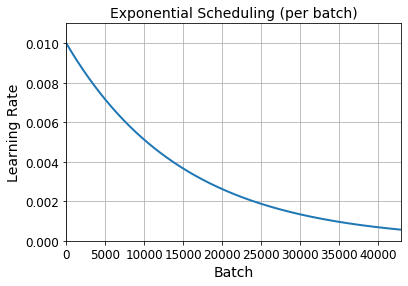

In [68]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

**구간별 고정 스케줄링**

일정 횟수의 에포크동안 일정한 학습률을 사용하고 또 다른 횟수의 에포크 동안 작은 학습률을 사용하는 방법이다. 잘 동작할 수 있지만 적절한 학습률과 에포크 횟수의 조합을 찾으려면 여러 가지를 시도해야 한다.

In [69]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [70]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 117us/sample - loss: 0.8948 - accuracy: 0.7483 - val_loss: 0.7323 - val_accuracy: 0.7788
Epoch 2/25
55000/55000 [==============================] - 6s 102us/sample - loss: 0.8119 - accuracy: 0.7577 - val_loss: 1.1811 - val_accuracy: 0.6858
Epoch 3/25
55000/55000 [==============================] - 6s 101us/sample - loss: 0.8648 - accuracy: 0.7493 - val_loss: 1.2180 - val_accuracy: 0.7036
Epoch 4/25
55000/55000 [==============================] - 6s 101us/sample - loss: 0.9750 - accuracy: 0.7065 - val_loss: 0.8883 - val_accuracy: 0.7024
Epoch 5/25
55000/55000 [==============================] - 6s 101us/sample - loss: 0.9603 - accuracy: 0.7136 - val_loss: 1.2482 - val_accuracy: 0.6350
Epoch 6/25
55000/55000 [==============================] - 6s 102us/sample - loss: 0.5960 - accuracy: 0.8123 - val_loss: 0.5662 - val_accuracy: 0.8440
Epoch 7/25
55000/55000 [===========================

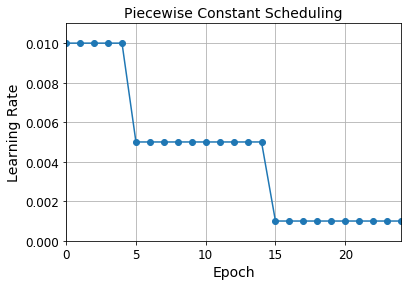

In [71]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

**성능 기반 스케줄링**

매 $N$스텝마다 검증 오차를 측정하고 오차가 줄어들지 않으면 $\lambda$배 만큼 학습률을 감소시킨다.

In [72]:
tf.random.set_seed(42)
np.random.seed(42)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 96us/sample - loss: 0.6131 - accuracy: 0.8034 - val_loss: 0.5470 - val_accuracy: 0.8098
Epoch 2/25
55000/55000 [==============================] - 5s 86us/sample - loss: 0.5148 - accuracy: 0.8384 - val_loss: 0.5110 - val_accuracy: 0.8316
Epoch 3/25
55000/55000 [==============================] - 5s 88us/sample - loss: 0.5229 - accuracy: 0.8433 - val_loss: 0.4830 - val_accuracy: 0.8582
Epoch 4/25
55000/55000 [==============================] - 5s 88us/sample - loss: 0.5111 - accuracy: 0.8463 - val_loss: 0.5296 - val_accuracy: 0.8476
Epoch 5/25
55000/55000 [==============================] - 5s 87us/sample - loss: 0.5303 - accuracy: 0.8483 - val_loss: 0.6190 - val_accuracy: 0.8294
Epoch 6/25
55000/55000 [==============================] - 5s 87us/sample - loss: 0.5125 - accuracy: 0.8536 - val_loss: 0.6550 - val_accuracy: 0.8354
Epoch 7/25
55000/55000 [==============================] -

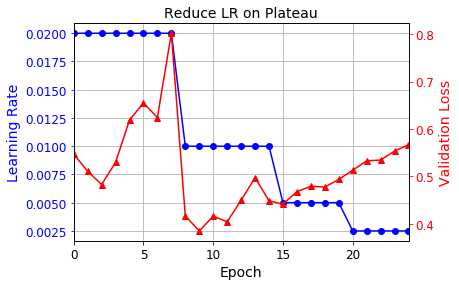

In [73]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

**tf.keras 스케줄러**

In [74]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 5s 90us/sample - loss: 0.4888 - accuracy: 0.8271 - val_loss: 0.4078 - val_accuracy: 0.8594
Epoch 2/25
55000/55000 [==============================] - 5s 82us/sample - loss: 0.3818 - accuracy: 0.8653 - val_loss: 0.3883 - val_accuracy: 0.8666
Epoch 3/25
55000/55000 [==============================] - 4s 81us/sample - loss: 0.3480 - accuracy: 0.8766 - val_loss: 0.3674 - val_accuracy: 0.8688
Epoch 4/25
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3265 - accuracy: 0.8835 - val_loss: 0.3518 - val_accuracy: 0.8788
Epoch 5/25
55000/55000 [==============================] - 4s 80us/sample - loss: 0.3100 - accuracy: 0.8900 - val_loss: 0.3429 - val_accuracy: 0.8790
Epoch 6/25
55000/55000 [==============================] - 4s 78us/sample - loss: 0.2961 - accuracy: 0.8947 - val_loss: 0.3404 - val_accuracy: 0.8816
Epoch 7/25
55000/55000 [==============================] -

In [75]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

In [76]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [77]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Train on 55000 samples
55000/55000 [==============================] - 2s 40us/sample - loss: 436799759473112030906417152.0000 - accuracy: 0.3895


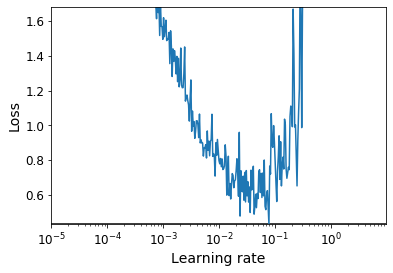

In [78]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [79]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [80]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 2s 36us/sample - loss: 0.6570 - accuracy: 0.7749 - val_loss: 0.4876 - val_accuracy: 0.8300
Epoch 2/25
55000/55000 [==============================] - 2s 32us/sample - loss: 0.4585 - accuracy: 0.8390 - val_loss: 0.4392 - val_accuracy: 0.8474
Epoch 3/25
55000/55000 [==============================] - 2s 32us/sample - loss: 0.4125 - accuracy: 0.8541 - val_loss: 0.4103 - val_accuracy: 0.8574
Epoch 4/25
55000/55000 [==============================] - 2s 32us/sample - loss: 0.3842 - accuracy: 0.8645 - val_loss: 0.3890 - val_accuracy: 0.8654
Epoch 5/25
55000/55000 [==============================] - 2s 32us/sample - loss: 0.3640 - accuracy: 0.8707 - val_loss: 0.3732 - val_accuracy: 0.8690
Epoch 6/25
55000/55000 [==============================] - 2s 32us/sample - loss: 0.3456 - accuracy: 0.8778 - val_loss: 0.3649 - val_accuracy: 0.8726
Epoch 7/25
55000/55000 [==============================] -

# 규제를 사용해 과대적합 피하기

## $l_1$과 $l_2$ 규제

In [81]:
layer = keras.layers.Dense(100, activation = 'elu', 
                           kernel_initializer = 'he_normal', 
                           kernel_regularizer = keras.regularizers.l2(0.01))

In [82]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 6s 115us/sample - loss: 1.5895 - accuracy: 0.8103 - val_loss: 0.7553 - val_accuracy: 0.8096
Epoch 2/2
55000/55000 [==============================] - 5s 99us/sample - loss: 0.7184 - accuracy: 0.8264 - val_loss: 0.7178 - val_accuracy: 0.8222


일반적으로 네트워크의 모든 은닉층에 동일한 활성화 함수, 동일한 초기화 전략을 사용하거나 모든 층에 동일한 규제를 적용하기 때문에 동일한 매개변수 값을 반복하는 경우가 많다. 이는 코드를 읽기 어렵게 만들고 버그를 만들기 쉽다. 이를 피하기 위해 반복문을 사용하도록 코드를 리팩터링 할 수 있다. 또 다른 방법은 파이썬의 `functools.partial()`을 사용하여 기본 매개변수 값을 사용하여 함수 호출을 감싸는 것이다.

In [84]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense, 
                           activation = 'elu', 
                           kernel_initializer = 'he_normal',
                           kernel_regularizer = keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs = n_epochs,
                    validation_data = (X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 6s 118us/sample - loss: 1.6418 - accuracy: 0.8107 - val_loss: 0.7600 - val_accuracy: 0.8068
Epoch 2/2
55000/55000 [==============================] - 5s 99us/sample - loss: 0.7197 - accuracy: 0.8262 - val_loss: 0.7175 - val_accuracy: 0.8254


## 드롭아웃

심층 신경망에서 가장 인기있는 규제 방법 중 하나이다. 매 훈련 스텝에서 각 뉴런(입력 뉴런은 포함하고 출력 뉴런은 제외)은 임시적으로 드롭아웃될 확률 $p$를 가진다. 즉, 이번 훈련 스텝에서는 완전히 무시되고 다음 스텝에서는 활성화될 수 있다. $p$를 드롭아웃 비율이라고 하고 보통 10%에서 50%의 값을 가진다. 순환 신경망에서는 2\~30%에 가깝고, 합성곱 신경망에서는 4\~50%에 가깝다. 훈련이 끝난 후에는 뉴런에 더는 드롭아웃을 적용하지 않는다. 

In [85]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 7s 122us/sample - loss: 0.5765 - accuracy: 0.8004 - val_loss: 0.3741 - val_accuracy: 0.8642
Epoch 2/2
55000/55000 [==============================] - 6s 108us/sample - loss: 0.4243 - accuracy: 0.8441 - val_loss: 0.3643 - val_accuracy: 0.8612


**알파 드롭아웃**

SELU 활성화 함수를 기반으로 자기 정규화하는 네트워크를 규제하고 싶을 때는 알파 드롭아웃을 사용해야 한다. 일반 드롭아웃이 자기 정규화하는 기능을 망가뜨릴 수 있기 때문이다.

In [86]:
tf.random.set_seed(42)
np.random.seed(42)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 6s 114us/sample - loss: 0.6628 - accuracy: 0.7608 - val_loss: 0.5845 - val_accuracy: 0.8404
Epoch 2/20
55000/55000 [==============================] - 6s 103us/sample - loss: 0.5567 - accuracy: 0.7965 - val_loss: 0.5322 - val_accuracy: 0.8470
Epoch 3/20
55000/55000 [==============================] - 6s 101us/sample - loss: 0.5241 - accuracy: 0.8049 - val_loss: 0.5379 - val_accuracy: 0.8504
Epoch 4/20
55000/55000 [==============================] - 6s 103us/sample - loss: 0.5078 - accuracy: 0.8133 - val_loss: 0.4733 - val_accuracy: 0.8624
Epoch 5/20
55000/55000 [==============================] - 6s 102us/sample - loss: 0.4950 - accuracy: 0.8173 - val_loss: 0.4753 - val_accuracy: 0.8592
Epoch 6/20
55000/55000 [==============================] - 6s 103us/sample - loss: 0.4808 - accuracy: 0.8224 - val_loss: 0.4501 - val_accuracy: 0.8658
Epoch 7/20
55000/55000 [===========================

## 몬테카를로 드롭아웃

드롭 아웃을 끄고 MNIST 테스트 세트에 있는 샘플을 예측하는 경우 거의 확실하게 앵클 부츠라고 확신한다. 

In [87]:
tf.random.set_seed(42)
np.random.seed(42)
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)
np.round(model.predict(X_test_scaled[:1]), 2)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],
      dtype=float32)

드롭아웃을 활성화하여 예측한 경우 위의 모델에 비해 더 이상 확신하지 않는다. 여전히 앵글 부츠를 선호하지만 클래스 5(샌들)이나 클래스 7(스니커즈)로도 생각한다. 모두 신발이라는 공통점이 있다.

In [88]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.28, 0.  , 0.69]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.08, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.19, 0.  , 0.01, 0.  , 0.81]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.93]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.35, 0.  , 0.63]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.54, 0.  , 0.45]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.17, 0.  , 0.72]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.25, 0.  , 0.74]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.41, 0.  , 0.02, 0.  , 0.57]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.44, 0.  , 0.14, 0.  , 0.42]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.17, 0.  , 0.73]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.22, 0.  , 0.64]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.32, 0.  , 0.24, 0.  , 0

첫 번째 차원으로 평균을 내면 다음과 같다.

In [90]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.15, 0.  , 0.7 ]],
      dtype=float32)

확률 추정의 표준 분포도 확인할 수 있다.

In [91]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.16, 0.  , 0.24]],
      dtype=float32)

In [94]:
y_pred = np.argmax(y_proba, axis=1)
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8674

모델이 훈련하는 동안 다르게 작동하는 층을 가지고 있다면(ex. BatchNormalization) 앞에서와 같이 훈련 모드를 강제로 설정하면 안 된다. 대신 Dropoup 층을 다음과 같은 MCDropout층으로 바꿔야 한다.

In [95]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

tf.random.set_seed(42)
np.random.seed(42)

mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])
mc_model.summary()


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_271 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_272 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_273 (Dense)            (None, 10)              

In [98]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

mc_model.set_weights(model.get_weights())

np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.2 , 0.  , 0.68]],
      dtype=float32)

## 맥스-노름 규제 

맥스-노름 규제는 각각의 뉴런에 대해 입력의 연결 가중치 $\mathbf{w}$가 ${\vert\vert \mathbf{w} \vert\vert}_2 \leq r$이 되도록 제한한다.

In [99]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 7s 131us/sample - loss: 0.4744 - accuracy: 0.8337 - val_loss: 0.3806 - val_accuracy: 0.8626
Epoch 2/2
55000/55000 [==============================] - 6s 109us/sample - loss: 0.3575 - accuracy: 0.8701 - val_loss: 0.3617 - val_accuracy: 0.8676


# Practice

## CIFAR10 이미지 데이터셋에 심층 신경망 훈련

### q8.1
100개의 뉴런을 가진 은닉층 20개로 심층 신경망 만들기. He 초기화와 ELU 활성화 함수 사용 

In [114]:
keras.backend.clear_session() 
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
for _ in range(20) : 
    model.add(keras.layers.Dense(100, 
                                 activation = 'elu',
                                 kernel_initializer = 'he_normal'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

### q8.2
Nadam 옵티마이저와 조기 종료를 사용하여 CIFAR10 데이터셋에 이 네트워크를 훈련. keras.datasets.cifar10.load_ data()를 사용하여 데이터를 적재할 수 있다. 이 데이터셋은 10개의 클래스와 32×32 크기의 컬러 이미지 60,000개로 구성된다.(50,000개는 훈련, 10,000개는 테스트). 따라서 10개의 뉴런과 소프트맥스 활성화 함수를 사용하는 출력층이 필요하다. 모델 구조와 하이퍼파라미터를 바꿀 때마다 적절한 학습률을 찾아야 한다.

In [115]:
# 모델에 출력층 추가 
model.add(keras.layers.Dense(10, activation = 'softmax'))

# 학습률 5e-5인 Nadam 옵티마이저 사용
optimizer = keras.optimizers.Nadam(learning_rate = 5e-5)
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = optimizer, 
              metrics = ['accuracy'])

In [116]:
# 데이터셋 로드 
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

# 콜백 생성하고 모델 훈련 
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

# fit
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

In [125]:
model = keras.models.load_model('my_cifar10_model.h5')
result = model.evaluate(X_valid, y_valid, verbose = False)
print(f'loss : {result[0]}')
print(f'accuracy : {result[1]}') 

loss : 1.517450470352173
accuracy : 0.4636000096797943


### q8.3
배치 정규화를 추가하고 학습 곡선을 비교해보기. 이전보다 빠르게 수렴하는가? 더 좋은 모델이 만들어지는가? 훈련 속도에는 어떤 영향을 미치는가?

위의 코드에서 다음의 몇 가지를 변경
- 출력층을 제외한 모든 Dense층 다음에 활성화 함수를 통과하기 전 단계에서 BN층을 추가한다. 처음 은닉층 전에도 BN층을 추가
- 확습률을 5e-4로 변경
- run_logdir을 `runbn*`으로 이름을 바꾸고 모델 파일 이름을 my_cifar10_bn_model.h5로 변경

In [119]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model.add(keras.layers.BatchNormalization())

for _ in range(20) : 
    model.add(keras.layers.Dense(100, kernel_initializer = 'he_normal'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('elu'))
    
model.add(keras.layers.Dense(10, activation = 'softmax'))

optimizer = keras.optimizers.Nadam(learning_rate = 5e-4)
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint('my_cifar10_bn_model.h5', save_best_only = True)
run_index = 1 
run_logdir = os.path.join(os.curdir, 'my_cifar10_logs', 'run_bn_{:03d}'.format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs = 100,
          validation_data = (X_valid, y_valid),
          callbacks = callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 26s 572us/sample - loss: 1.8387 - accuracy: 0.3424 - val_loss: 1.6547 - val_accuracy: 0.4090
Epoch 2/100
45000/45000 [==============================] - 17s 388us/sample - loss: 1.6657 - accuracy: 0.4047 - val_loss: 1.6127 - val_accuracy: 0.4232
Epoch 3/100
45000/45000 [==============================] - 17s 388us/sample - loss: 1.5958 - accuracy: 0.4326 - val_loss: 1.5732 - val_accuracy: 0.4462
Epoch 4/100
45000/45000 [==============================] - 17s 387us/sample - loss: 1.5531 - accuracy: 0.4505 - val_loss: 1.5078 - val_accuracy: 0.4634
Epoch 5/100
45000/45000 [==============================] - 17s 386us/sample - loss: 1.5070 - accuracy: 0.4640 - val_loss: 1.4747 - val_accuracy: 0.4676
Epoch 6/100
45000/45000 [==============================] - 17s 387us/sample - loss: 1.4643 - accuracy: 0.4783 - val_loss: 1.4127 - val_accuracy: 0.4900
Epoch 7/100
45000/45000 [==============

[1.3140383172988892, 0.5418]

In [124]:
model = keras.models.load_model('my_cifar10_bn_model.h5')
result = model.evaluate(X_valid, y_valid, verbose = False)
print(f'loss : {result[0]}')
print(f'accuracy : {result[1]}') 

loss : 1.3140383172988892
accuracy : 0.5418000221252441


- 이전보다 훨씬 빠르게 수렴한다. BN층은 훈련을 안정적으로 수행하고 더 큰 학습률을 사용할 수 있기 때문에 수렴이 빨라졌다. 
- 최종 모델의 성능이 더 좋다. 
- 각 층에서 걸리는 시간은 증가하지만 실제 훈련 시간은 크게 줄어들었다.

### q8.4
배치 정규화를 SELU로 바꾸어보기. 네트워크가 자기 정규화하기 위해 필요한 변경 사항을 적용해보기(즉, 입력 특성 표준화, 르쿤 정규분포 초기화, 완전 연결 층만 순차적으로 쌓은 심층 신경망 등).

In [126]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 14s 314us/sample - loss: 1.9322 - accuracy: 0.3091 - val_loss: 1.8659 - val_accuracy: 0.3424
Epoch 2/100
45000/45000 [==============================] - 11s 245us/sample - loss: 1.7173 - accuracy: 0.3925 - val_loss: 1.7085 - val_accuracy: 0.3880
Epoch 3/100
45000/45000 [==============================] - 11s 245us/sample - loss: 1.6173 - accuracy: 0.4316 - val_loss: 1.6958 - val_accuracy: 0.3914
Epoch 4/100
45000/45000 [==============================] - 11s 246us/sample - loss: 1.5546 - accuracy: 0.4516 - val_loss: 1.6386 - val_accuracy: 0.4212
Epoch 5/100
45000/45000 [==============================] - 11s 243us/sample - loss: 1.4974 - accuracy: 0.4747 - val_loss: 1.6416 - val_accuracy: 0.4310
Epoch 6/100
45000/45000 [==============================] - 11s 244us/sample - loss: 1.4457 - accuracy: 0.4928 - val_loss: 1.5158 - val_accuracy: 0.4780
Epoch 7/100
45000/45000 [==============

In [131]:
model = keras.models.load_model('my_cifar10_selu_model.h5')
result = model.evaluate(X_valid_scaled, y_valid, verbose = False)
print(f'loss : {result[0]}')
print(f'accuracy : {result[1]}') 

loss : 1.466315245437622
accuracy : 0.5088000297546387


### q8.5
알파 드롭아웃으로 모델에 규제를 적용해보고 그 다음 모델을 다시 훈련하지 않고 MC 드롭아웃으로 더 높은 정확도를 얻을 수 있는지 확인

In [128]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 15s 330us/sample - loss: 1.9091 - accuracy: 0.3243 - val_loss: 1.7338 - val_accuracy: 0.3868
Epoch 2/100
45000/45000 [==============================] - 12s 256us/sample - loss: 1.6702 - accuracy: 0.4120 - val_loss: 1.6606 - val_accuracy: 0.4246
Epoch 3/100
45000/45000 [==============================] - 11s 254us/sample - loss: 1.5754 - accuracy: 0.4455 - val_loss: 1.6776 - val_accuracy: 0.4144
Epoch 4/100
45000/45000 [==============================] - 11s 254us/sample - loss: 1.5159 - accuracy: 0.4695 - val_loss: 1.6422 - val_accuracy: 0.4292
Epoch 5/100
45000/45000 [==============================] - 11s 254us/sample - loss: 1.4568 - accuracy: 0.4878 - val_loss: 1.5842 - val_accuracy: 0.4526
Epoch 6/100
45000/45000 [==============================] - 11s 254us/sample - loss: 1.4071 - accuracy: 0.5074 - val_loss: 1.5197 - val_accuracy: 0.4712
Epoch 7/100
45000/45000 [==============

In [132]:
model = keras.models.load_model('my_cifar10_alpha_dropout_model.h5')
result = model.evaluate(X_valid_scaled, y_valid, verbose = False)
print(f'loss : {result[0]}')
print(f'accuracy : {result[1]}') 

loss : 1.5064839542388917
accuracy : 0.4941999912261963


### q8.6
1사이클 스케줄링으로 모델을 다시 훈련하고 훈련 속도와 모델 정확도가 향상되는지 확인

Train on 45000 samples
45000/45000 [==============================] - 5s 111us/sample - loss: nan - accuracy: 0.1363


[1e-05, 9.615228, 2.0901217, 3.6135973249162947]

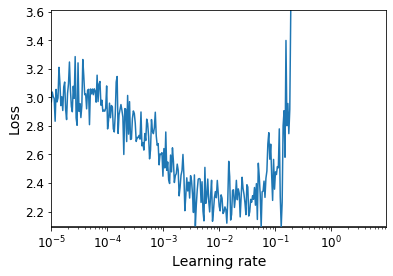

In [134]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [135]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
n_epochs = 15
onecycle = OneCycleScheduler(len(X_train_scaled) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 5s 120us/sample - loss: 2.0510 - accuracy: 0.2846 - val_loss: 1.7857 - val_accuracy: 0.3794
Epoch 2/15
45000/45000 [==============================] - 4s 89us/sample - loss: 1.7597 - accuracy: 0.3765 - val_loss: 1.6453 - val_accuracy: 0.4198
Epoch 3/15
45000/45000 [==============================] - 4s 89us/sample - loss: 1.6272 - accuracy: 0.4211 - val_loss: 1.5908 - val_accuracy: 0.4414
Epoch 4/15
45000/45000 [==============================] - 4s 89us/sample - loss: 1.5482 - accuracy: 0.4487 - val_loss: 1.5798 - val_accuracy: 0.4498
Epoch 5/15
45000/45000 [==============================] - 4s 90us/sample - loss: 1.4994 - accuracy: 0.4697 - val_loss: 1.6467 - val_accuracy: 0.4290
Epoch 6/15
45000/45000 [==============================] - 4s 88us/sample - loss: 1.4592 - accuracy: 0.4827 - val_loss: 1.5792 - val_accuracy: 0.4576
Epoch 7/15
45000/45000 [==============================] 